两个实现应该来讲可以交叉验证
* https://github.com/ssw-nlp-study-group/nlp_study/blob/main/nlp/word2vec_negative_sampling.py
* https://blog.csdn.net/qq_24668285/article/details/121754529

通过交叉验证发现，forward部分的实现原理是一样的。但是到底为什么会是酱紫的，可以再看看原理。

https://blog.csdn.net/csdn_xmj/article/details/118702420

In [1]:
# -*- ecoding: utf-8 -*-
# @Author: anyang
# @Time: 2021/1/29 2:13 下午

import torch
import torch.nn as nn
import torch.utils.data as tud
from collections import Counter
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# 由于word2vec的skip gram方法在单词数很大的情况下需要训练费用无法承受
# 因此使用负样本采样的方法代替，节省训练时间，并且结果上也是近似 将一个多分类问题转换为多个二分类问题

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../runs/word2vec_skip_gram_negative_sampling')

# 判断是否有GPU
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.cuda.manual_seed(1)

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../runs/word2vec_skip_gram_negative_sampling')

In [3]:
def get_words(data_file):
    lines = []
    with open(data_file, encoding="UTF-8") as file:
        for line in file:
            lines.append(line.strip())

    sentence = " ".join(lines) ## 把原文档拼成一行。
    words = sentence.split(" ") ## 把原文里面所有的单词得到。感觉这种方法不太高明啊。
    words_set = list(set(words)) 

    words_freq_num = Counter(words).most_common(len(words_set))
    # print(words_freq_num)
    words_freq_p = np.array([freq for word, freq in words_freq_num])
    # print(words_freq_p)
    words_freq_p = words_freq_p ** (3. / 4.) ## 这个3/4次方是论文里提到的方法。
    # print(words_freq_p)
    words_freq_p = words_freq_p / np.sum(words_freq_p)
    # print(words_freq_p)

    words2id = {w: i for i, w in enumerate(words_set)}
    id2words = {i: w for i, w in enumerate(words_set)}

    return lines, words2id, id2words, words_set, words, np.array(words_freq_num), np.array(words_freq_p)

In [4]:
lines, words2id, id2words, words_set, words, words_freq_num, words_freq_p =\
get_words(data_file=f"../originalDataset/negative_sampling_data.txt")

In [5]:
words_freq_num

array([['橘子', '1'],
       ['香蕉', '1'],
       ['苹果', '1'],
       ['梨子', '1'],
       ['葡萄', '1'],
       ['柠檬', '1'],
       ['猪', '1'],
       ['狗', '1'],
       ['羊', '1'],
       ['牛', '1'],
       ['兔子', '1'],
       ['老鼠', '1'],
       ['马', '1'],
       ['龙', '1'],
       ['鸡', '1'],
       ['电脑', '1'],
       ['洗衣机', '1'],
       ['冰箱', '1'],
       ['音响', '1'],
       ['手机', '1'],
       ['收音机', '1']], dtype='<U21')

In [6]:
words_freq_p

array([0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905])

In [7]:
def get_skip_pairs(lines, context_size):
    '''
    说白了，这个函数就是要获得每一个单词的上下文单词。
    '''
    skip_grams = []
    for line in lines:
        words = line.split(" ")
        for i, w in enumerate(words):
            context_words = words[max(i - context_size, 0):max(i, 0)] + words[i + 1:i + context_size + 1]
            skip_grams.append((w, context_words))
    return skip_grams

In [8]:
lines

['橘子 香蕉 苹果 梨子 葡萄 柠檬', '猪 狗 羊 牛 兔子 老鼠 马 龙 鸡', '电脑 洗衣机 冰箱 音响 手机 收音机']

In [9]:
get_skip_pairs(lines, 2)

[('橘子', ['香蕉', '苹果']),
 ('香蕉', ['橘子', '苹果', '梨子']),
 ('苹果', ['橘子', '香蕉', '梨子', '葡萄']),
 ('梨子', ['香蕉', '苹果', '葡萄', '柠檬']),
 ('葡萄', ['苹果', '梨子', '柠檬']),
 ('柠檬', ['梨子', '葡萄']),
 ('猪', ['狗', '羊']),
 ('狗', ['猪', '羊', '牛']),
 ('羊', ['猪', '狗', '牛', '兔子']),
 ('牛', ['狗', '羊', '兔子', '老鼠']),
 ('兔子', ['羊', '牛', '老鼠', '马']),
 ('老鼠', ['牛', '兔子', '马', '龙']),
 ('马', ['兔子', '老鼠', '龙', '鸡']),
 ('龙', ['老鼠', '马', '鸡']),
 ('鸡', ['马', '龙']),
 ('电脑', ['洗衣机', '冰箱']),
 ('洗衣机', ['电脑', '冰箱', '音响']),
 ('冰箱', ['电脑', '洗衣机', '音响', '手机']),
 ('音响', ['洗衣机', '冰箱', '手机', '收音机']),
 ('手机', ['冰箱', '音响', '收音机']),
 ('收音机', ['音响', '手机'])]

In [10]:
class word_embedding_dataset(tud.Dataset):
    def __init__(self, skip_grams):
        super(word_embedding_dataset, self).__init__()
        self.skip_grams = skip_grams

    def __len__(self):
        return len(self.skip_grams)

    def __getitem__(self, idx):
        return self.skip_grams[idx]


def find_nearest_k(word, k):
    '''
    这个就很显然了。寻找跟word最像的k个单词。
    '''
    wid = words2id[word]
    w_vec = wordvec[wid]

    similarity = wordvec @ w_vec.T
    sort = np.sort(similarity)[::-1]
    sort_arg = np.argsort(similarity)[::-1]

    result = []
    for i in sort_arg:
        result.append(id2words[i])

    print("与 %s 相似度排序" % word, result)

    return result[:k]

In [11]:
class embedding_model(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(embedding_model, self).__init__()
        self.voc_size = voc_size
        self.emb_size = emb_size

        init_range = 0.5 / self.emb_size
        self.in_embed = nn.Embedding(num_embeddings=self.voc_size, embedding_dim=emb_size)
        self.in_embed.weight.data.uniform_(-init_range, init_range) ## 我怀疑这个的意思是按照某种分布（uniform），生成某范围内的数值来初始化参数
        self.out_embed = nn.Embedding(num_embeddings=self.voc_size, embedding_dim=emb_size)
        self.out_embed.weight.data.uniform_(-init_range, init_range)

    def forward(self, input_labels, pos_labels, neg_labels):
        '''
        输入参数名字里面的label我总觉得有一些误导性，实际上应该是index吧。
        '''
        # shape (1,embedding_size)
        input_embedding = self.in_embed(input_labels)
        # shape (context_size,embedding_size)
        pos_embedding = self.out_embed(pos_labels)
        neg_embedding = self.out_embed(neg_labels)

        input_embedding = input_embedding.unsqueeze(2) ## 变成(1, embedding_size, 1)
        # print("input_embedding: ", input_embedding.size())
        pos_embedding = pos_embedding.unsqueeze(0) ## 变成(1, context_size, embedding_size)
        # print("pos_embedding: ", pos_embedding.size())
        neg_embedding = neg_embedding.unsqueeze(0)

        pos_dot = torch.bmm(pos_embedding, input_embedding) ## (1, context_size, 1)
        # print("pos_dot: ", pos_dot.size())
        neg_dot = torch.bmm(neg_embedding, -input_embedding)

        # 正样本
        log_pos = torch.sigmoid(pos_dot).sum(1) ## (1, 1)
        # print("torch.sigmoid(pos_dot).sum(1)", torch.sigmoid(pos_dot).sum(1))
        # 负样本
        log_neg = torch.sigmoid(neg_dot).sum(1)

        loss = (-log_pos - log_neg).squeeze() ## 把两个部分的logit加起来，取相反数。我怎么觉得这里不太对劲，难道不应该是-log_pos + log_neg吗？
        return loss

-3.502588987350464
-3.999926805496216
-3.506493091583252
-4.571134090423584
-4.626928329467773
-4.6111159324646
-3.9755728244781494
-4.919957637786865
-4.0158538818359375
-6.339545249938965
-6.094932556152344
-8.249215126037598
-6.048399448394775
-6.589468479156494
-4.862904071807861
-5.799762725830078
-6.878992080688477
in_embed.weight Parameter containing:
tensor([[-0.5439,  1.7315,  1.1067,  0.3626,  1.0088, -0.3547, -0.4186,  1.0471],
        [ 0.8736, -0.6747, -1.9054, -1.0974,  0.4093, -1.2663,  0.7302, -0.4865],
        [-0.0171,  1.2406,  1.2650,  0.7522,  0.5946, -0.8517, -0.5177,  1.0918],
        [ 1.1086,  0.2772, -1.4757, -1.1954,  0.3241, -0.7477,  0.9878, -0.8893],
        [ 0.3647,  1.0288,  1.4437,  0.5225,  0.4326, -1.0316, -0.4966,  0.2638],
        [ 0.2258,  1.2009,  1.6470,  0.5341,  0.9298, -0.9575, -0.6354,  0.6581],
        [ 0.1586,  1.2078,  1.5422,  0.6504,  0.8917, -0.8086, -0.6243,  1.0452],
        [-0.7561, -0.5491,  0.6392,  0.2798, -1.5445,  1.5659, -0

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22855 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minkexiu/opt/anaconda3/lib/python3.9/site-p

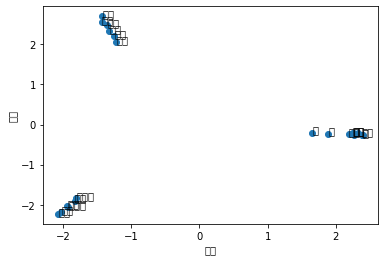

与 猪 相似度排序 ['羊', '牛', '马', '兔子', '老鼠', '狗', '龙', '猪', '鸡', '橘子', '电脑', '葡萄', '收音机', '柠檬', '手机', '梨子', '音响', '洗衣机', '冰箱', '香蕉', '苹果']
['羊', '牛', '马', '兔子']


In [14]:
def words2id_func(words):
    return np.array([words2id[w] for w in words])


if __name__ == '__main__':
    data_file = "../originalDataset/negative_sampling_data.txt"
    model_file = "../trainedModel/word2vec_negative_sampling.pkl"
    # 设定超参数（hyper parameters）
    # 负采样个数k
    k = 5
    embedding_size = 8
    context_size = 2
    lr = 1e-2
    num_epoch = 800

    # 数据处理
    lines, words2id, id2words, words_set, words, words_freq_num, words_freq_p = \
        get_words(data_file=data_file)

    # 不重复单词个数
    voc_size = len(words_set)

    # 根据文本获取 训练数据 pairs [(input,output),...]
    skip_grams = get_skip_pairs(lines, context_size=2)
    # print(skip_grams)

    model = embedding_model(voc_size=voc_size, emb_size=embedding_size)

    dataset = word_embedding_dataset(skip_grams=skip_grams)

    # indexs = torch.multinomial(torch.Tensor(words_freq_p), k, replacement=True) ## 应该是按照多项式分布，有放回的，采样k个。

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    word_freq_indexs = {} ## 把前面得到的words_freq_num这个list里面的word的排列顺序给它搞出来。为的是后续能够从word_freq_p里面拿到对应的p
    for i, (word, freq) in enumerate(words_freq_num): ## 
        word_freq_indexs[word] = i

    index = 0
    # 词向量训练部分
    for j in range(num_epoch):
        for i, skip_gram in enumerate(dataset): ## 这里就可以看作是一行一行地扫描原始数据了。
            center_word = words2id[skip_gram[0]] ## 中心词的id
            context_words_id = [words2id[word] for word in skip_gram[1]] ## 上下文词的id
            context_words = skip_gram[1] ## 上下文词
            p = words_freq_p.copy()

            for context in context_words:
                p[word_freq_indexs[context]] = 0 ## 把上下文词对应的freq_p替换为0。我猜是为了不取这些数？

            # 对负样本-即非 target的部分按照频率归一化后的概率进行采样
            # 正样本部分保持不变
            # 取样个数取决于k值
            neg_words_sample = torch.multinomial(torch.Tensor(p), k, replacement=True)
#             print(neg_words_sample, "neg_words_sample")
            neg_words = words2id_func(words_freq_num[neg_words_sample.numpy()][:, 0])
#             print(
#                 words_freq_num[neg_words_sample.numpy()][:, 0], "words_freq_num"
#             )
#             print(neg_words, "neg_words")
            ##### 上面这几行是做什么的呢？是为了采样一些单词，这些单词不是context words，所以算是负样本。
            ##### 采样出来的neg_words就是若干个非context_words的id。
            
            context_words = words2id_func(context_words)
            ## 这行，就是得到了context words的id。

            optimizer.zero_grad()
#             print(torch.LongTensor([center_word]), torch.LongTensor(context_words), torch.LongTensor(neg_words))
            loss = model(torch.LongTensor([center_word]), torch.LongTensor(context_words), torch.LongTensor(neg_words))
            if index % 1000 == 0:
                print(loss.item())

            loss.backward()
            optimizer.step()
            writer.add_scalar("loss", loss.item(), index)
            index += 1

    # 保存模型
    torch.save(model, model_file)

    model = torch.load(model_file)
    for name, param in model.named_parameters():
        print(name, param)
        # 获取in_embed的参数作为词向量 out_embed可舍弃
        if name == "in_embed.weight":
            wordvec = param.data.numpy()

    # 利用pca对词向量进行降维 方便画图展示
    pca = PCA(n_components=2)
    result = pca.fit_transform(wordvec)
    plt.scatter(result[:, 0], result[:, 1])
#     print(id2words)
#     print(words_set)

    for i in range(voc_size):
        plt.annotate(id2words[i], xy=(result[i, 0], result[i, 1]))

    plt.xlabel('奇数')
    plt.ylabel('偶数')
    plt.show()

    # 获取最相近的k个词向量
    result = find_nearest_k('猪', k=4)
    print(result) ## 